# Vtuber analytics

В этом небольшом исследовании мы рассмотрим данные о чатах и донатах витуберов - ютуб или твитч стримеров, использующих цифровые аватары. Витуберы особенно популярны в Японии, из-за чего унаследовали некоторые особенности айдол-культуры. Например, витуберы гораздо реже, чем западные контент-мейкеры, работают самостоятельно. Большинство известных витуберов принадлежит к агентствам, которые обеспечивают их пиаром и оборудованием. 

Я бы хотел рассмотреть, как выглядит рынок витуберов, какая его часть занята агентствами и в каких пропорциях. Также рассмотрим такую метрику как эффективность агентства - то, сколько в среднем зарабатывает витубер агентство с одного витубера. Рассмотрим, как эффективность распределена между агентствами, как она соотносится с общей выручкой агентств. Посмотрим на региональные особенности, где датасет позволяет (чёткого разбиения на регионы в нём нет). Также с помощью sklearn и PyTorch попробуем найти неочевидные относительные метрики чатов и супер-чатов, которые могут влиять на заработок витубера.

In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vtuber-livechat-elements/chat_stats.csv
/kaggle/input/vtuber-livechat-elements/superchat_stats.csv
/kaggle/input/vtuber-livechat-elements/channels.csv


In [36]:
# импортируем датасеты

channels = pd.read_csv('/kaggle/input/vtuber-livechat-elements/channels.csv')
chat_stats = pd.read_csv('/kaggle/input/vtuber-livechat-elements/chat_stats.csv')
superchat_stats = pd.read_csv('/kaggle/input/vtuber-livechat-elements/superchat_stats.csv')

In [37]:
print(superchat_stats) # посмотрим, как они выглядят

                      channelId   period  superChats  uniqueSuperChatters  \
0      UCFKOVgVbGmX65RxO3EtH3iw  2021-03        5552                 1043   
1      UCV5ZZlLjk5MKGg3L0n0vbzw  2021-03         220                  121   
2      UCvaTdHTWBGv3MKj3KVqJVCw  2021-03        2653                  796   
3      UCNVEsYbiZjH5QLmGeSgTSzg  2021-03         166                  124   
4      UCl_gCybOJRIgOXw6Qb4qJzQ  2021-03        3468                  835   
...                         ...      ...         ...                  ...   
10937  UCYV0ojRpol74EwfVSuuqWxA  2022-07          36                   12   
10938  UC-KMgJ1wl9DUV63HiUSGOXw  2022-07          26                   19   
10939  UCHPfTzszxxBC2whb9vWaHPg  2022-07           1                    1   
10940  UCDXFo9upBYHPfreF9IGK25g  2022-07           2                    2   
10941  UCyIcOCH-VWaRKH9IkR8hz7Q  2022-07           1                    1   

       totalSC  averageSC  totalMessageLength  averageMessageLength  \
0   

In [38]:
channels.describe()

,subscriptionCount,videoCount
count,1.358000e+03,1358.000000
mean,1.783210e+05,318.184831
std,3.264973e+05,342.408773
min,0.000000e+00,0.000000
25%,2.290000e+04,90.000000
50%,5.665000e+04,210.000000
75%,1.800000e+05,436.000000
max,4.100000e+06,3353.000000


In [39]:
chat_stats.describe()

,chats,memberChats,uniqueChatters,uniqueMembers,bannedChatters,deletedChats
count,1.246800e+04,1.246800e+04,12468.000000,12468.00000,12468.000000,12468.000000
mean,1.216989e+05,5.790535e+04,5365.060234,530.92589,39.077318,39.284809
std,2.667930e+05,1.548827e+05,11595.823924,1352.02882,227.433782,240.661663
min,1.000000e+00,0.000000e+00,1.000000,0.00000,0.000000,0.000000
25%,8.201000e+03,6.675000e+01,405.000000,6.00000,0.000000,0.000000
50%,3.207550e+04,8.947500e+03,1241.000000,100.00000,3.000000,0.000000
75%,1.037952e+05,4.164725e+04,4314.750000,359.00000,14.000000,5.000000
max,4.318661e+06,2.622691e+06,224155.000000,22710.00000,11379.000000,15840.000000


In [40]:
superchat_stats.describe()

,superChats,uniqueSuperChatters,totalSC,averageSC,totalMessageLength,averageMessageLength
count,10942.000000,10942.000000,1.094200e+04,10942.00000,1.094200e+04,10942.000000
mean,528.961159,188.276366,6.273763e+05,1164.05913,1.657172e+04,27.204076
std,1323.747445,417.975955,1.650828e+06,805.48285,4.439424e+04,15.306613
min,1.000000,1.000000,5.100000e+01,51.00000,0.000000e+00,0.000000
25%,40.000000,22.000000,3.867350e+04,678.00000,8.280000e+02,17.000000
50%,163.000000,66.000000,1.651970e+05,987.00000,3.351500e+03,22.000000
75%,471.000000,175.000000,5.012255e+05,1443.00000,1.124500e+04,33.000000
max,49855.000000,13566.000000,4.885828e+07,25500.00000,1.157348e+06,200.000000


In [41]:
# проверим, есть ли в датасетах пропуски

print(channels.isna().sum())
print(chat_stats.isna().sum())
print(superchat_stats.isna().sum()) # датасеты в целом обработаны, не обработан только пропуск группы

channelId              0
name                   0
englishName            0
affiliation            0
group                929
subscriptionCount      0
videoCount             0
photo                  0
dtype: int64
channelId         0
period            0
chats             0
memberChats       0
uniqueChatters    0
uniqueMembers     0
bannedChatters    0
deletedChats      0
dtype: int64
channelId               0
period                  0
superChats              0
uniqueSuperChatters     0
totalSC                 0
averageSC               0
totalMessageLength      0
averageMessageLength    0
mostFrequentCurrency    0
mostFrequentColor       0
dtype: int64


In [42]:
channels.group.unique() # группа - это команда витуберов внутри одного агентства. Как правило, витуберы из одной группы часто стримят вместе.

array([nan, 'CyberLive', 'Generation1', 'Generation2', 'Generation3',
       'Official', 'Phase Connect', 'TAMAKI', 'Gen 1', 'Wave 1', 'Gamers',
       'Gen 2', 'SEEDS', 'Wave 2', 'Wave 2019', 'Generation4',
       'Wave 2020', 'ID', 'Wave 2021', 'HIYOCRO', 'Wave 2022',
       'VOLTACTION', 'AniMare', 'HoneyStrap', 'SugarLyric', 'Tsunderia',
       'VApArt', 'First Phase', 'JP Gen 1', 'Phase Invaders', '2nd Phase',
       'Nijisanji EN', 'JP 候補生', 'Nijisanji ID', 'Nijisanji KR',
       'VirtuaReal (CN)', 'Collab', 'Generation 0', '1st Generation',
       'Generation 2', '2nd Generation', 'GAMERS', 'Generation 3',
       '3rd Generation', '4th Generation', '5th Generation',
       '6th Generation (HoloX)', 'English (Myth)', 'English (CouncilRyS)',
       'Kaibutsu', 'Indonesia 1st Gen', 'Indonesia 2nd Gen',
       'Indonesia 3rd Gen', 'Holostars 1st Gen', 'Holostars 2nd Gen',
       'Holostars 3rd Gen', 'Holostars UPROAR', 'Holostars English',
       'Shinengumi', 'mocora', 'Misc', 'INA

In [43]:
channels.group = channels.group.fillna('No group') # если группа не указана, будем считать, что её нет

In [44]:
# Проверим, какие агентства включены в датасет
channels.affiliation.unique() # есть все и даже больше, хороший датасет

array(['Hololive', 'Aetheria', 'PRISM', 'Nijisanji', 'Phase Connect',
       'Nori Pro', 'MAHA5', '774inc', 'Tsunderia', 'Independents',
       '.LIVE', 'Emoechi', 'VOMS', 'Axel-V', 'ReAcT', 'Atelier Live',
       'Chukorara', 'Unreal Night Girls', 'Production Kawaii', 'WACTOR',
       'GuildCQ', 'Twitch Independents', 'Hoshimeguri Gakuen', 'AkioAIR',
       'VShojo', 'Polygon', 'Cloud Horizon', 'KEMOMIMI REFLE',
       'Pink Punk Pro', 'SquareLive', 'La Peche Party', 'KAMITSUBAKI',
       'H.Live', 'ReMemories', 'ProPro', 'Masquerade', 'Kizuna Ai Inc.',
       'Yume Reality', 'VSpo', 'NIJIGEN', 'Riot Music', 'Snacknili',
       'Aogiri Highschool', 'Shinsougumi', 'Neo-Porte', "X enc'ount",
       'Marbl_s', 'Kemono Friends', 'Eilene Family', 'idol Corp', 'ViViD',
       'V Dimension.Creators', 'MyHolo TV', 'Pixela Project',
       'WAK Entertainment', 'KAWAII MUSIC', 'Iridori', 'VOICE-ORE',
       'Sleep Monster', 'Yuni Create'], dtype=object)

Давайте посмотрим, какие агентства получают больше всего донатов и кто занимает наибольшую долю рынка.
Смотрим данные за последние 3 месяца, т.к. некоторые агентства могли появиться совсем недавно. Скорее всего, Nijisanji и Hololive разделят первое и второе место, вопрос - какую часть рынка они контролируют? Учитывая, что Hololive настолько сильна, что своим приходом на англоязычный рынок витуберов по сути создала его таким, какой он есть сейчас, а Nijisanji в Японии даже больше Hololive, доля эта должна быть подавляющей.

In [45]:
# переведём "период" в datetime формат для удобства работы
superchat_stats.period = pd.to_datetime(superchat_stats.period)
chat_stats.period = pd.to_datetime(chat_stats.period)

# достанем нужные нам столбцы
df1 = pd.DataFrame(columns = ['group', 'SC_amount', 'affilated_channels_amount'])

for aff in channels.affiliation.unique():
    affilated_channels = channels.channelId[channels.affiliation==aff]
    affilated_channels_amount = affilated_channels.count()
    SC_amount = superchat_stats.totalSC[(superchat_stats.channelId.isin(affilated_channels)) & (superchat_stats.period >= '2022-05')].sum()
    df1 = df1._append({'group': aff, 'SC_amount': SC_amount, 'affilated_channels_amount': affilated_channels_amount}, ignore_index=True)

In [46]:
# получим топ агентств по выручке
print(df1.sort_values(by=['SC_amount'], ascending=False)[:8])

                group  SC_amount affilated_channels_amount
3           Nijisanji  502042961                       207
0            Hololive  405421209                        92
9        Independents  138469393                       470
5            Nori Pro   32960260                        13
7              774inc   24842653                        31
38               VSpo   21661396                        16
43        Shinsougumi   16550245                         8
42  Aogiri Highschool   16322173                         8


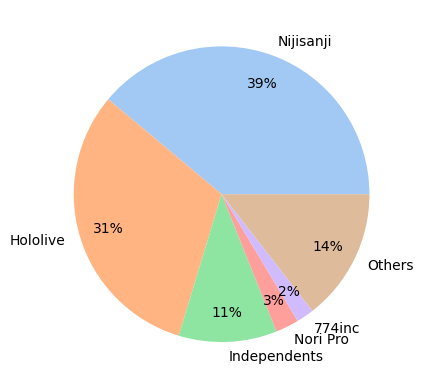

In [47]:
# давайте теперь представим это пайчартом
import matplotlib.pyplot as plt
import seaborn as sns # используем seaborn чтобы навести красоту

border = 5
df_cut = df1.sort_values(by=['SC_amount'], ascending=False)
others_SC = df_cut[border:].SC_amount.sum()
others_amt = df_cut[border:].affilated_channels_amount.sum()
df_cut = df_cut[:border]
df_cut = df_cut._append({'group': 'Others', 'SC_amount': others_SC, 'affilated_channels_amount': others_amt}, ignore_index=True)

colors = sns.color_palette('pastel')[0:border+1]
plt.pie(df_cut.SC_amount, labels=df_cut.group, colors=colors, autopct='%.0f%%', pctdistance=0.8)
plt.show()

Как видим, Nijisanji и Hololive вдвоём контролируют 70% рынка. Такая вот олигополия. Третье по силе агентство, Nori Pro, в 13 раз меньше Nijisanji.

Но насколько эти агентства эффективны, какая у них выручка на витубера? Т.к. доходы стримеров скейлятся экспоненциально, то Hololive и Nijisanji должны так же занимать первые места, но, быть может, в топ также пробьётся какое-нибудь небольшое агентство. 

In [48]:
# получим топ агентств по эффективности
df1['SC_per_talent'] = df1['SC_amount'] / df1['affilated_channels_amount']
print(df1.sort_values(by=['SC_per_talent'], ascending=False)[:10])

                group  SC_amount affilated_channels_amount   SC_per_talent
0            Hololive  405421209                        92  4406752.271739
5            Nori Pro   32960260                        13  2535404.615385
3           Nijisanji  502042961                       207   2425328.31401
43        Shinsougumi   16550245                         8     2068780.625
42  Aogiri Highschool   16322173                         8     2040271.625
38               VSpo   21661396                        16      1353837.25
44          Neo-Porte   10497773                         8     1312221.625
40         Riot Music   10828929                         9  1203214.333333
24             VShojo   14254661                        15   950310.733333
7              774inc   24842653                        31   801375.903226


Действительно, Hololive и Nijisanji в топе, но на второе место пробралась Nori Pro, 3-е агентство по размеру, по общей выручке меньшее Nijisanji в 13 раз. Также можно заметить, что у Hololive феноменальные доходы на витубера, почти в два раза больше, чем у Nijisanji (при количестве витуберов также почти в два раза меньшем). Видимо, быть витубером Hololive всё же более престижно, пусть это агентство и немного поменьше Nijisanji по общей выручке.

Давайте представим этот топ красиво. Используем мега замороченный бар чарт с круглыми краями и своим шрифтом. Для этого придётся использовать Altair, т.к. matplotlib и seaborn плохо справляются с круглыми углами.

In [49]:
import altair as alt

altair_size = 20
border = 10
df_cut = df1.sort_values(by=['SC_per_talent'], ascending=False)
others_SC = df_cut[border:].SC_amount.sum()
others_amt = df_cut[border:].affilated_channels_amount.sum()
df_cut = df_cut[:border]
df_cut = df_cut._append({'group': 'Others', 'SC_amount': others_SC, 'affilated_channels_amount': others_amt, 'SC_per_talent':(others_SC/others_amt)}, ignore_index=True)

bars = alt.Chart(df_cut).mark_bar(
    color='turquoise',
    cornerRadiusTopLeft=altair_size/2,
    cornerRadiusTopRight=altair_size/2,
    size = altair_size
).encode(
    x=alt.X('group', title='Group'),
    y=alt.Y('SC_per_talent', title='evenue per vtuber, ¥')
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    dy=-5,  # Move text above the bar
    font='Aleo',  # Set the font to Aleo
    fontSize=12, # Set the font size to 12
    fontWeight='bold'
).encode(
    text=alt.Text('SC_per_talent', format='.2f')  # Encode the text with the mean yield value
)

chart = alt.layer(bars, text).configure_axisX(
    grid=False,
    title="Team size"
).configure_axis(
    gridDash=[3, 3], # add dashes
    labelFont='Aleo',   # Change font of axis labels
    labelFontSize=10,          # Size of axis labels
    labelFontWeight='bold',    # Make axis labels bold
    titleFont='Aleo',   # Change font of axis title
    titleFontSize=12,          # Size of axis title
    titleFontWeight='bold', # Make axis title bold
    titleColor='#515151',
    labelColor='#515151'
).configure_title(
    font='Aleo',        # Change font of title
    fontSize=26,               # Size of title
    fontWeight='bold'       # Make title bold
).properties(
    title='Vtuber agencies 3 month revenue per vtuber, ¥',
    width=700,
    height=300
)
chart

alt.LayerChart(...)

Давайте посмотрим среднюю рыночную эффективность и нарисуем её на этом графике. Эта диаграма напоминает экспоненциальную, так что Hololive, скорее всего, будет значительно сильнее рынка - вопрос насколько? Далее поиспользуем график попроще, т.к. с пайплотом всё же работать приятнее. Вот, кстати, предыдущий график сделанный только в pyplot и seaborn, а также отсортированный по величине выручки:

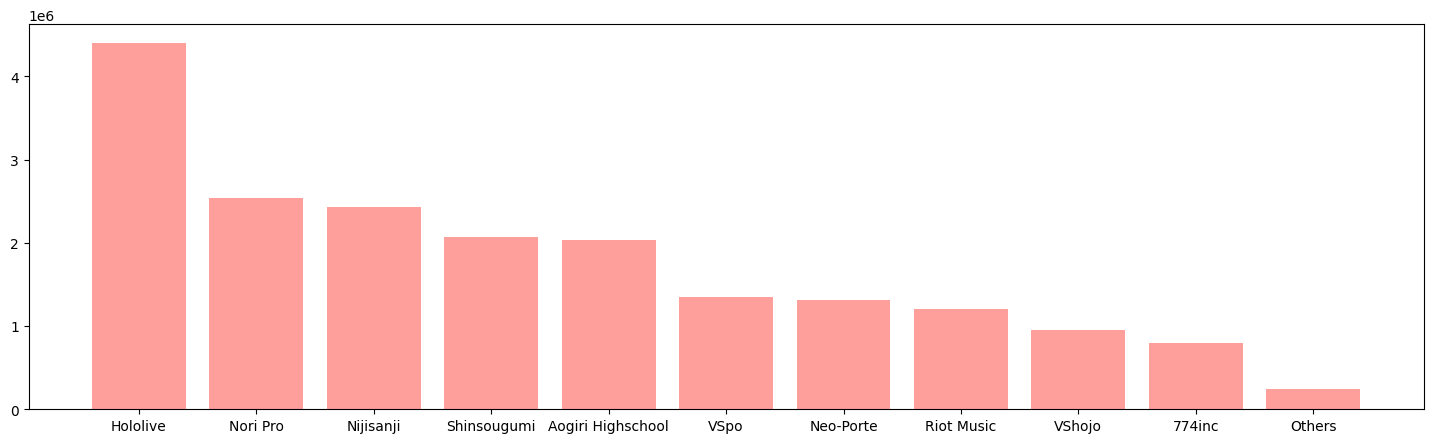

In [50]:
fig = plt.figure(figsize =(18, 5))
plt.bar(df_cut.group, df_cut.SC_per_talent, color = colors[3])
plt.show()

In [51]:
market_efficiency = df1.SC_amount.sum() / df1.affilated_channels_amount.sum()
market_efficiency

950266.1605301915

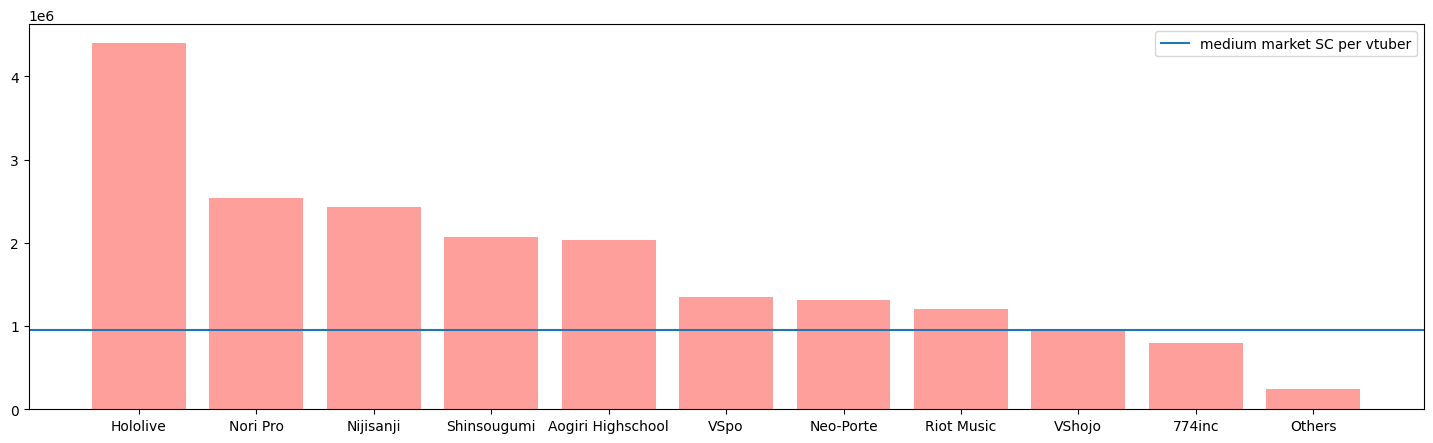

In [52]:
fig = plt.figure(figsize =(18, 5))
plt.bar(df_cut.group, df_cut.SC_per_talent, color = colors[3])
plt.axhline(y=market_efficiency, label='medium market SC per vtuber')
plt.legend()
plt.show()

Интересно, что VSojo, агентство с одними из самых известных англоязычных витуберов, работает на эффективности лишь средней по рынку. Японские фанаты настолько круче английских? 

Hololive превышает среднюю эффективность почти в 4.6 раз, Nijisanji - примерно в 2.5 раза.

Теперь давайте посмотрим, насколько эти агентства лучше независимых витуберов. Вероятно, разница будет столь значительна, что по графику будет тяжело сказать, во сколько раз агентства эффективнее.

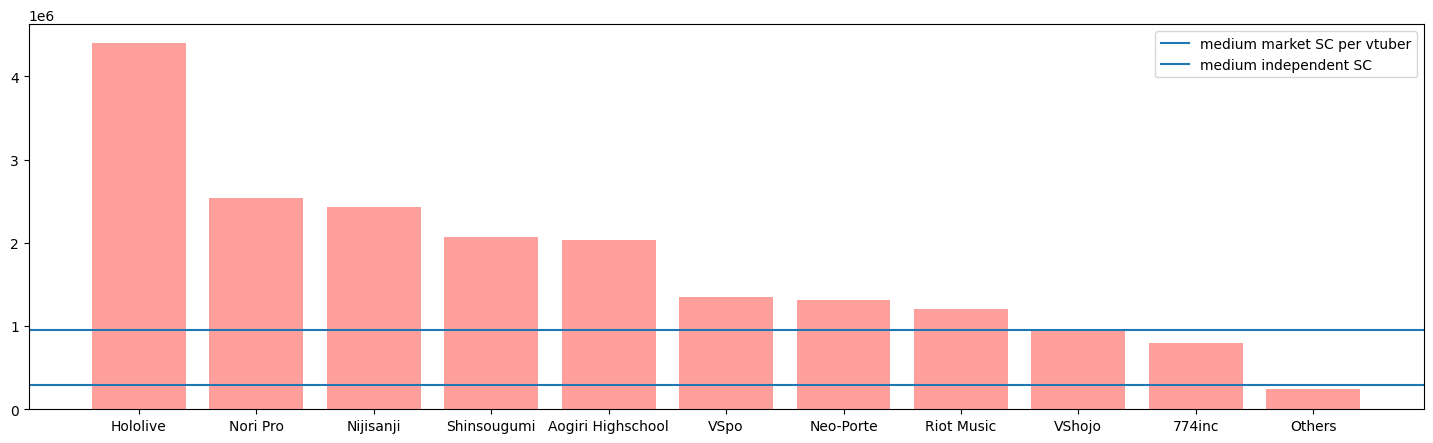

In [53]:
independent_efficiency = df1[df1.group == 'Independents'].SC_per_talent.sum()

fig = plt.figure(figsize =(18, 5))
plt.bar(df_cut.group, df_cut.SC_per_talent, color = colors[3])
plt.axhline(y=market_efficiency, label='medium market SC per vtuber')
plt.axhline(y=independent_efficiency, label='medium independent SC')
plt.legend()
plt.show()

In [54]:
print(independent_efficiency)

294615.72978723404


Может, эффективность VSojo и не выше средней эффективности по маркету, но уж точно в 2-3 раза выше средней эффективности независимого витубера. Учитывая, что агентства проводят определённый отбор для своих талантов, плюс помогают им с маркетингом и оборудованием, это не так удивительно.

Было бы интересно уметь предсказывать доход витубера в зависимости от таких относительных величин, как отношение чатов к уникальным зрителям, отношение чатов от платных подписчиков к их количеству, аналогичная статистика для супер чатов. Также можем добавить характеристики mostFrequentCurrency (самая частая валюта, в которой кидают донаты), averageMessageLength. Хочется ещё добавить средний размер доната, но это может привести к утечке таргета в трейнинг, так что не будем. Агентство или группу тоже не добавим, т.к. очевидно там есть слишком мощная корреляция с доходом витубера.

In [55]:
# почти все данные у нас численные, надо разобраться только с mostFrequentCurrency
superchat_stats.mostFrequentCurrency.unique()

# Валют много. Для простоты будем использовать one hot encoding с тремя вариантами: йеной, долларом и "остальными валютами"

array(['JPY', 'USD', 'CAD', 'KRW', 'TWD', 'PHP', 'GBP', 'RUB', 'EUR',
       'MXN', 'INR', 'BRL', 'ARS', 'AUD', 'SGD', 'COP', 'HKD', 'CLP',
       'MYR', 'PEN', 'NOK', 'BGN', 'CHF', 'HNL', 'DKK', 'BYN', 'PLN',
       'ILS', 'IDR', 'QAR'], dtype=object)

In [56]:
# будем использовать данные за последний доступный в датасете год
chat_stats_cut = chat_stats[chat_stats.period>='2021-07']
superchat_stats_cut = superchat_stats[superchat_stats.period>='2021-07']

# как видим, в датасете есть каналы, которым писали в чат, но не донатили
print(superchat_stats_cut.channelId.nunique())
print(chat_stats_cut.channelId.nunique())

# т.к. выражение ниже даёт пустой сет, нет каналов, которые получали донат, но не получали сообщение в чате.
print(set(superchat_stats_cut.channelId.unique()) - set(chat_stats_cut.channelId.unique()))

1072
1222
set()


In [57]:
# создадим датасет с описанными выше характеристиками

df2 = {'SC_amount':[], 'chats_to_unique': [], 'member_chats_to_unique': [], 'banned_chats_to_unique': [],
      'superchats_to_unique': [], 'average_length': [], 'freq_currency': []}
for unique_id in chat_stats_cut.channelId.unique():
    df2['SC_amount'].append(superchat_stats_cut.totalSC[superchat_stats_cut.channelId == unique_id].mean())
    df2['chats_to_unique'].append((chat_stats_cut.chats[chat_stats_cut.channelId == unique_id] / chat_stats_cut.uniqueChatters[chat_stats_cut.channelId == unique_id]).mean())
    df2['member_chats_to_unique'].append((chat_stats_cut.memberChats[chat_stats_cut.channelId == unique_id] / chat_stats_cut.uniqueMembers[chat_stats_cut.channelId == unique_id]).mean())
    df2['banned_chats_to_unique'].append((chat_stats_cut.bannedChatters[chat_stats_cut.channelId == unique_id] / chat_stats_cut.uniqueMembers[chat_stats_cut.channelId == unique_id]).mean())
    df2['superchats_to_unique'].append((superchat_stats_cut.superChats[superchat_stats_cut.channelId == unique_id] / superchat_stats_cut.uniqueSuperChatters[superchat_stats_cut.channelId == unique_id]).mean())
    df2['average_length'].append(superchat_stats_cut.averageMessageLength[superchat_stats_cut.channelId == unique_id].mean())
    df2['freq_currency'].append(superchat_stats_cut.mostFrequentCurrency[superchat_stats_cut.channelId == unique_id].mode().values)
    
df2 = pd.DataFrame(df2)
    

In [58]:
df2['freq_currency'] = df2['freq_currency'].replace([], None)

In [59]:
df2['freq_currency'] = df2['freq_currency'].apply(lambda x: x[0] if (len(x) > 0) else None)

Как мы видим, тут довольно много пропусков

In [60]:
df2

,SC_amount,chats_to_unique,member_chats_to_unique,banned_chats_to_unique,superchats_to_unique,average_length,freq_currency
0,4.670453e+05,63.430031,280.228417,0.005494,3.618904,15.000000,JPY
1,2.367342e+07,4.828728,13.599587,0.006662,1.144446,47.000000,JPY
2,3.924993e+05,28.726517,114.493504,0.027596,1.667078,20.769231,JPY
3,5.175922e+05,36.467822,195.748997,1.384575,4.302829,55.307692,ARS
4,3.652543e+05,55.720200,187.967785,0.106372,2.781412,24.000000,JPY
...,...,...,...,...,...,...,...
1217,NaN,15.348131,NaN,inf,NaN,NaN,None
1218,NaN,15.696296,182.500000,5.000000,NaN,NaN,None
1219,NaN,9.227982,NaN,inf,NaN,NaN,None
1220,NaN,42.463415,NaN,NaN,NaN,NaN,None


Для начала обработаем валюты как планировали

In [61]:
df2.freq_currency[~df2['freq_currency'].isin(['JPY', 'USD', None])] = 'OTHER'

/tmp/ipykernel_33/3393723536.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df2.freq_currency[~df2['freq_currency'].isin(['JPY', 'USD', None])] = 'OTHER'
/tmp/ipykernel_33/3393723536.py:1: SettingWithCopyWarning: 
A value is trying to b

In [62]:
one_hot = pd.get_dummies(df2['freq_currency'])

In [63]:
df2 = df2.join(one_hot)

In [64]:
df2

,SC_amount,chats_to_unique,member_chats_to_unique,banned_chats_to_unique,superchats_to_unique,average_length,freq_currency,JPY,OTHER,USD
0,4.670453e+05,63.430031,280.228417,0.005494,3.618904,15.000000,JPY,True,False,False
1,2.367342e+07,4.828728,13.599587,0.006662,1.144446,47.000000,JPY,True,False,False
2,3.924993e+05,28.726517,114.493504,0.027596,1.667078,20.769231,JPY,True,False,False
3,5.175922e+05,36.467822,195.748997,1.384575,4.302829,55.307692,OTHER,False,True,False
4,3.652543e+05,55.720200,187.967785,0.106372,2.781412,24.000000,JPY,True,False,False
...,...,...,...,...,...,...,...,...,...,...
1217,NaN,15.348131,NaN,inf,NaN,NaN,None,False,False,False
1218,NaN,15.696296,182.500000,5.000000,NaN,NaN,None,False,False,False
1219,NaN,9.227982,NaN,inf,NaN,NaN,None,False,False,False
1220,NaN,42.463415,NaN,NaN,NaN,NaN,None,False,False,False


In [65]:
# удалим бесконечности
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

In [66]:
df2.isna().any()

SC_amount                  True
chats_to_unique           False
member_chats_to_unique     True
banned_chats_to_unique     True
superchats_to_unique       True
average_length             True
freq_currency              True
JPY                       False
OTHER                     False
USD                       False
dtype: bool

Во всех полях довольно удобно будет заменить NaN на 0, т.к. как правило отсутствие значения SC обозначает отсутствие донатов, отсутствие соотношения чатов к чатерам - отсутствие чатеров. С длиной сообщения чуть сложнее, т.к. не факт, что у непопулярных стримеров более короткие сообщения. Поставим длину сообщения в среднее.

In [67]:
df2.SC_amount = df2.SC_amount.fillna(0)
df2.member_chats_to_unique = df2.member_chats_to_unique.fillna(0)
df2.banned_chats_to_unique = df2.banned_chats_to_unique.fillna(0)
df2.superchats_to_unique = df2.superchats_to_unique.fillna(0)
df2.average_length = df2.average_length.fillna(df2.average_length.mean())

In [68]:
df2

,SC_amount,chats_to_unique,member_chats_to_unique,banned_chats_to_unique,superchats_to_unique,average_length,freq_currency,JPY,OTHER,USD
0,4.670453e+05,63.430031,280.228417,0.005494,3.618904,15.000000,JPY,True,False,False
1,2.367342e+07,4.828728,13.599587,0.006662,1.144446,47.000000,JPY,True,False,False
2,3.924993e+05,28.726517,114.493504,0.027596,1.667078,20.769231,JPY,True,False,False
3,5.175922e+05,36.467822,195.748997,1.384575,4.302829,55.307692,OTHER,False,True,False
4,3.652543e+05,55.720200,187.967785,0.106372,2.781412,24.000000,JPY,True,False,False
...,...,...,...,...,...,...,...,...,...,...
1217,0.000000e+00,15.348131,0.000000,0.000000,0.000000,28.079035,None,False,False,False
1218,0.000000e+00,15.696296,182.500000,5.000000,0.000000,28.079035,None,False,False,False
1219,0.000000e+00,9.227982,0.000000,0.000000,0.000000,28.079035,None,False,False,False
1220,0.000000e+00,42.463415,0.000000,0.000000,0.000000,28.079035,None,False,False,False


Дропнем freq_currency чтобы избавиться от строковых данных и нормализуем всё

In [69]:
df2_normalized = df2.drop(columns=['freq_currency'])

In [70]:
df2_normalized = df2_normalized.replace({True: 1, False: 0})
for column in df2_normalized.columns: 
    df2_normalized[column] = df2_normalized[column]  / df2_normalized[column].abs().max() 

/tmp/ipykernel_33/719257051.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2_normalized = df2_normalized.replace({True: 1, False: 0})


In [71]:
df2_normalized

,SC_amount,chats_to_unique,member_chats_to_unique,banned_chats_to_unique,superchats_to_unique,average_length,JPY,OTHER,USD
0,0.011641,0.315939,0.511452,0.000334,0.237686,0.171920,1.0,0.0,0.0
1,0.590047,0.024051,0.024821,0.000405,0.075166,0.538682,1.0,0.0,0.0
2,0.009783,0.143084,0.208965,0.001678,0.109492,0.238043,1.0,0.0,0.0
3,0.012901,0.181643,0.357266,0.084169,0.282605,0.633899,0.0,1.0,0.0
4,0.009104,0.277537,0.343065,0.006466,0.182680,0.275072,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1217,0.000000,0.076448,0.000000,0.000000,0.000000,0.321823,0.0,0.0,0.0
1218,0.000000,0.078182,0.333085,0.303951,0.000000,0.321823,0.0,0.0,0.0
1219,0.000000,0.045964,0.000000,0.000000,0.000000,0.321823,0.0,0.0,0.0
1220,0.000000,0.211507,0.000000,0.000000,0.000000,0.321823,0.0,0.0,0.0


Теперь построим простую линейную регрессию из sklearn

In [72]:
# разобьём на таргет и параметры
y = df2_normalized['SC_amount']
X = df2_normalized.drop(columns=['SC_amount'])

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# разобьём датасет на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = LinearRegression().fit(X_train, y_train) 
MSE = mean_squared_error(y_test, model.predict(X_test))
score = model.score(X_test, y_test)
print('MSE:', MSE)
print('score:', score) # в целом, как и ожидалось, предсказательная сила так себе

MSE: 0.0006042736455620205
score: 0.1360891856643126


Давайте посмотрим, какие параметры прежде всего влиют на оценку:

In [74]:
print(X_train.columns)
print(model.coef_)

Index(['chats_to_unique', 'member_chats_to_unique', 'banned_chats_to_unique',
       'superchats_to_unique', 'average_length', 'JPY', 'OTHER', 'USD'],
      dtype='object')
[-0.02833169  0.00171216 -0.07769237  0.03444424  0.08527788  0.01770596
 -0.0018691  -0.01253476]


Веса укрепляют теорию про преданность японских фанатов - иена в качестве валюты это положительный фактор, другие валюты - отрицательный. Интересно, что вес доллара ещё больше уходит в отрицательные значения, чем вес "других" валют - возможно, потому что условные индонезийцы или другие азиаты с сильной айдол-культурой донатят даже больше американцев и перевешивают "неплатящие" нации. 

Самый сильный положительный фактор, как ни странно, длина сообщения. Видимо, у более популярных стримеров всё же более вдумчивые донатеры.

Высокая частота банов, наоборот, плохой показатель, что кажется немного странным - кажется, что у малых стримеров не так много рандомных троллей, которых нужно банить. Возможно, если банов слишком много, это показывает, что сам стример не совсем адекватный?

Но в общем и целом, все факторы весьма незначительны. Наша модель работает не сильно лучше чем та, которая выдаёт лишь среднее. Попробуем построить модель чуть посложнее с помощью PyTorch.

In [75]:
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# конвертим в тензоры, делаем датасет
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# далаем даталоудер
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# прописываем нашу модель
model_torch = nn.Sequential(
            nn.Linear(8, 6),
            nn.ReLU(),
            nn.Linear(6, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
)

# определяем функцию потерь и оптимизатор
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_torch.parameters(), lr=0.001)

In [76]:
def train_model(model, train_loader, optimizer, loss_fn, epochs=5):
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            # Делаем предсказание и считаем его потери
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            
            # Бэкпроп
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# треним
train_model(model_torch, train_loader, optimizer, loss_fn, epochs=50)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.10187773406505585
Epoch 1, Loss: 0.07961629331111908
Epoch 2, Loss: 0.05582645162940025
Epoch 3, Loss: 0.0386384055018425
Epoch 4, Loss: 0.028115155175328255
Epoch 5, Loss: 0.02146856300532818
Epoch 6, Loss: 0.01073237881064415
Epoch 7, Loss: 0.010587372817099094
Epoch 8, Loss: 0.010035394690930843
Epoch 9, Loss: 0.023482153192162514
Epoch 10, Loss: 0.005168763920664787
Epoch 11, Loss: 0.00403751851990819
Epoch 12, Loss: 0.0027147801592946053
Epoch 13, Loss: 0.003975810948759317
Epoch 14, Loss: 0.002964430721476674
Epoch 15, Loss: 0.002866496564820409
Epoch 16, Loss: 0.002298540435731411
Epoch 17, Loss: 0.0022280358243733644
Epoch 18, Loss: 0.005716151092201471
Epoch 19, Loss: 0.002427083905786276
Epoch 20, Loss: 0.001711995922960341
Epoch 21, Loss: 0.0029284118209034204
Epoch 22, Loss: 0.0012442420702427626
Epoch 23, Loss: 0.001809696201235056
Epoch 24, Loss: 0.0017532934434711933
Epoch 25, Loss: 0.002983472542837262
Epoch 26, Loss: 0.0017821344081312418
Epoch 27, Los

In [77]:
# Теперь давайте оценим эффективность модели
def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            total_loss += loss.item()
        print(f"Average Test Loss: {total_loss / len(test_loader)}")

evaluate_model(model_torch, test_loader)
print('Sklearn model loss:', MSE)

Average Test Loss: 0.0008083768355261002
Sklearn model loss: 0.0006042736455620205


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Увы, но особо улучшить ситуацию с помощью PyTorch не вышло.

**Подводя итоги:**
1) Hololive и Nijisanji, два крупнейших агентства, в сумме занимают 70% рынка.

2) Подход максимизирования доходов на витубера при сравнительно меньшем количестве витуберов может работать также эффективно, как и подход увеличения количества витуберов в ущерб среднего дохода, что показывает пример Hololive и Nijisanji.

3) Витуберы в агентствах в среднем зарабатывают существенно больше, чем независимые витуберы. Витуберы Hololive, самого эффективного агентства, в среднем зарабатывают в 15 раз больше, чем независимые витуберы.

4) Японские фанаты поддерживают витуберов значительно сильнее, чем западные. Витуберы самого сильного агентства США, VShojo, имеют лишь среднюю рыночную эффективность, что в 4.6 раза меньше, чем в топовом японском агентстве, Hololive. Более того, тот факт, что наиболее частой валютой в донатах витубера была не иена, а доллар, был негативным. Интересный результат, учитывая, что японцев меньше и они не такие платёжеспособные, как жители США.

5) Метрики вроде количества сообщений на уникального чатера или количества сообщений от подписчиков на уникальных подписчиков имеют крайне слабую взаимосвязь с тем, сколько витубер зарабатывает. Это значит, что нет смысла пытаться таргетить определённые значения данных метрик. Средняя длина сообщения в суперчате и то имеет больший эффект, хотя и его нельзя назвать значительным.